### Loading Packages and Data

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [8]:
ls /mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/vv/alabama/2023_06_02_18_00_54/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
intervention_person_time.csv     transition_count.csv
intervention_person_time.hdf     transition_count.hdf
ldlc_medication_person_time.csv  ylds.csv
ldlc_medication_person_time.hdf  ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [9]:
sim_results_dir = '/mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/vv/alabama/2023_06_02_18_00_54/count_data/'

### Exploring Data

In [10]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

Unnamed: 0     sex  year                  cause measure  input_draw  \
0           0  female  2023  acute_ischemic_stroke  deaths          29   
1           1  female  2023  acute_ischemic_stroke  deaths          29   
2           2  female  2023  acute_ischemic_stroke  deaths          29   
3           3  female  2023  acute_ischemic_stroke  deaths          29   
4           4  female  2023  acute_ischemic_stroke  deaths          29   

        scenario       age  value  
0       baseline  25_to_29    1.0  
1  lifestyle_100  25_to_29    1.0  
2   lifestyle_50  25_to_29    1.0  
3   outreach_100  25_to_29    1.0  
4    outreach_50  25_to_29    1.0

In [11]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
#tran.transition.unique()

In [12]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

696659390.1054071

# DALYs Averted

In [13]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year','scenario']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year','scenario']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 
daly_total = daly_total.groupby(['sex','input_draw','year','scenario']).daly.sum().reset_index()
daly_total.head()

sex  input_draw  year       scenario          daly
0  female          29  2023       baseline  84207.339166
1  female          29  2023  lifestyle_100  84207.242173
2  female          29  2023   lifestyle_50  84207.242173
3  female          29  2023   outreach_100  84193.488580
4  female          29  2023    outreach_50  84193.639013

In [8]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age','sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.loc[person_time.age != '25_to_29']
per_time_age = per_time_age.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex  year  input_draw       scenario        ptvalue
0  female  2023          29       baseline  259725.086927
1  female  2023          29  lifestyle_100  259725.086927
2  female  2023          29   lifestyle_50  259725.086927
3  female  2023          29   outreach_100  259725.240246
4  female  2023          29    outreach_50  259725.240246

In [9]:
daly_total_rate = daly_total.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex  input_draw  year       scenario          daly        ptvalue  \
0  female          29  2023       baseline  84207.339166  259725.086927   
1  female          29  2023  lifestyle_100  84207.242173  259725.086927   
2  female          29  2023   lifestyle_50  84207.242173  259725.086927   
3  female          29  2023   outreach_100  84193.488580  259725.240246   
4  female          29  2023    outreach_50  84193.639013  259725.240246   

   daly_rate  
0   0.324217  
1   0.324217  
2   0.324217  
3   0.324164  
4   0.324164

In [10]:
daly_total_baseline = daly_total.loc[daly_total.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly':'baseline'})
daly_total = daly_total.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total['averted_count'] = daly_total['daly'] - daly_total['baseline']
daly_total['averted_percent'] = 100*((daly_total['daly'] - daly_total['baseline'])/daly_total['baseline'])
daly_total.head()

sex  input_draw  year       scenario          daly      baseline  \
0  female          29  2023       baseline  84207.339166  84207.339166   
1  female          29  2023  lifestyle_100  84207.242173  84207.339166   
2  female          29  2023   lifestyle_50  84207.242173  84207.339166   
3  female          29  2023   outreach_100  84193.488580  84207.339166   
4  female          29  2023    outreach_50  84193.639013  84207.339166   

   averted_count  averted_percent  
0       0.000000         0.000000  
1      -0.096994        -0.000115  
2      -0.096994        -0.000115  
3     -13.850586        -0.016448  
4     -13.700153        -0.016270

In [11]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total_rate['averted_count'] = daly_total_rate['daly_rate'] - daly_total_rate['baseline']
daly_total_rate['averted_percent'] = 100*((daly_total_rate['daly_rate'] - daly_total_rate['baseline'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex  input_draw  year       scenario          daly        ptvalue  \
0  female          29  2023       baseline  84207.339166  259725.086927   
1  female          29  2023  lifestyle_100  84207.242173  259725.086927   
2  female          29  2023   lifestyle_50  84207.242173  259725.086927   
3  female          29  2023   outreach_100  84193.488580  259725.240246   
4  female          29  2023    outreach_50  84193.639013  259725.240246   

   daly_rate  baseline  averted_count  averted_percent  
0   0.324217  0.324217   0.000000e+00         0.000000  
1   0.324217  0.324217  -3.734475e-07        -0.000115  
2   0.324217  0.324217  -3.734475e-07        -0.000115  
3   0.324164  0.324217  -5.351923e-05        -0.016507  
4   0.324164  0.324217  -5.294003e-05        -0.016329

In [12]:
daly_sum_count = (daly_total
                .groupby(['sex','year','scenario'])
                .averted_count.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_count.head()

sex  year       scenario       mean       2.5%     97.5%
0  female  2023       baseline   0.000000   0.000000  0.000000
1  female  2023  lifestyle_100  -0.585451  -4.303550  0.000000
2  female  2023   lifestyle_50  -0.570120  -4.301531  0.000000
3  female  2023   outreach_100 -30.166254 -83.094553 -0.239164
4  female  2023    outreach_50 -23.708013 -75.588310 -0.099544

In [13]:
daly_sum_percent = (daly_total
                .groupby(['sex','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100 -0.000646 -0.004723  0.000000
2  female  2023   lifestyle_50 -0.000628 -0.004723  0.000000
3  female  2023   outreach_100 -0.038233 -0.113909 -0.000290
4  female  2023    outreach_50 -0.030091 -0.100927 -0.000115

In [14]:
daly_rate_percent = (daly_total_rate
                .groupby(['sex','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_rate_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100 -0.000658 -0.004815  0.000000
2  female  2023   lifestyle_50 -0.000640 -0.004815  0.000000
3  female  2023   outreach_100 -0.038393 -0.114102 -0.000290
4  female  2023    outreach_50 -0.030185 -0.101227 -0.000115

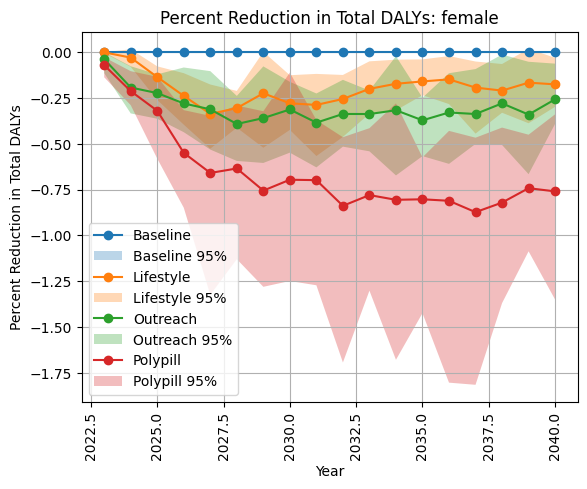

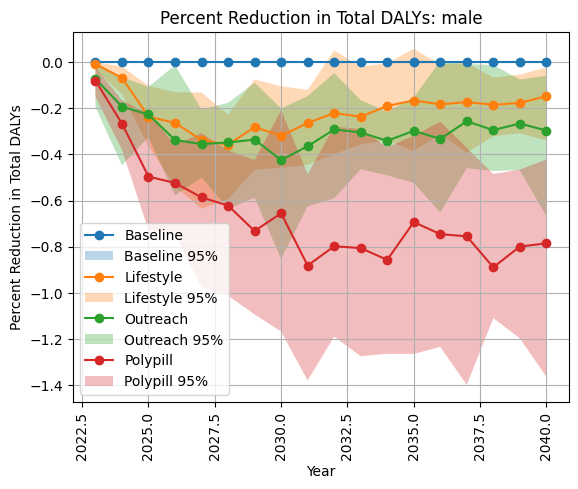

In [15]:
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Total DALYs: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')


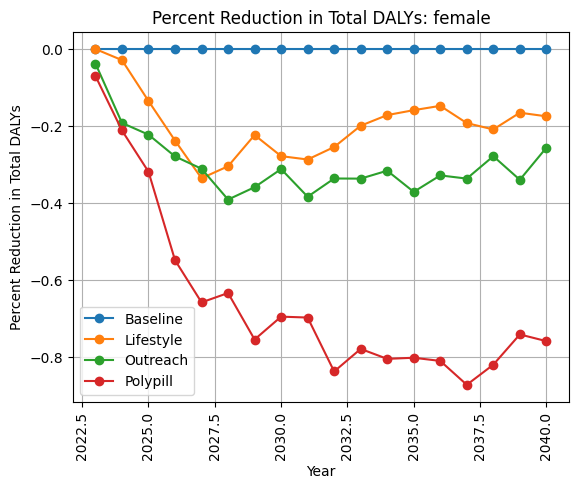

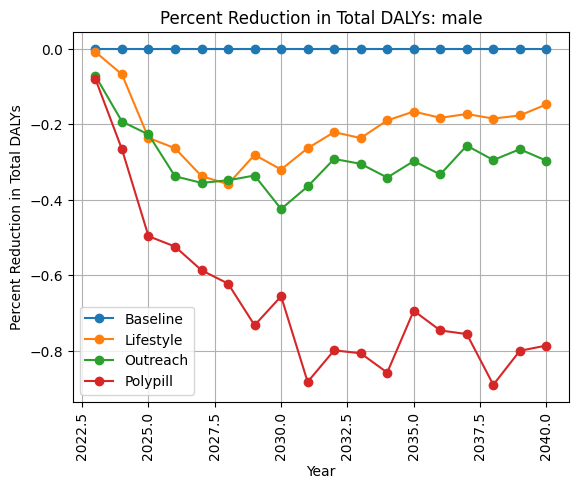

In [16]:
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.title(f'Percent Reduction in Total DALYs: {sex}')
    plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')


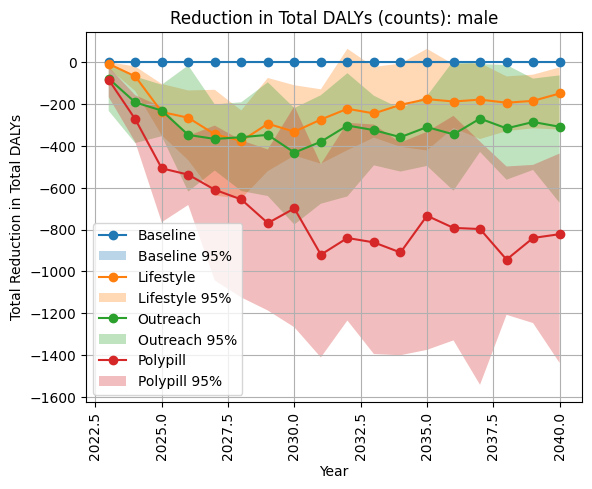

In [17]:
for sex in daly_sum_count.sex.unique(): 
    plt.figure()
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Reduction in Total DALYs (counts): {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in Total DALYs')

Note: this has NOT been multipled up to represent all of Alabama. It is useful for visualization but not the actual value of numbers. 

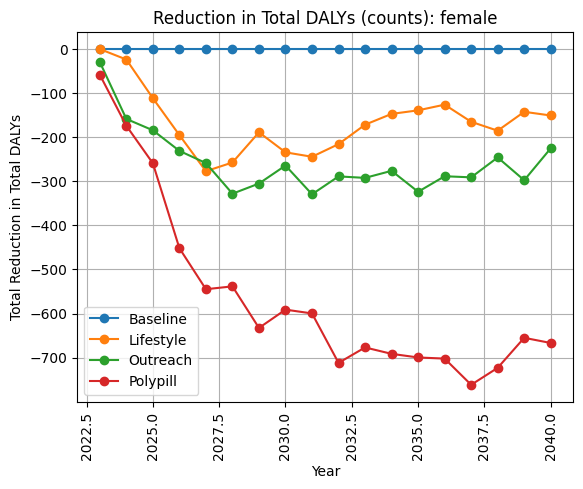

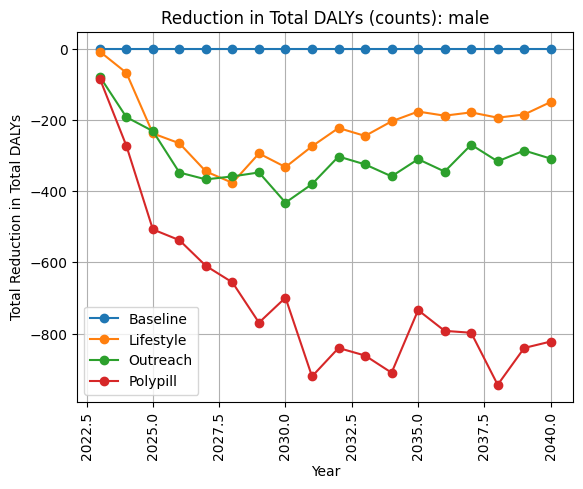

In [18]:
for sex in daly_sum_count.sex.unique(): 
    plt.figure()
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    subdata = daly_sum_count.loc[(daly_sum_count.sex==sex) & (daly_sum_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.title(f'Reduction in Total DALYs (counts): {sex}')
    plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in Total DALYs')

## DALYs Averted by Age Group

In [33]:
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 
daly_total['age_bucket'] = np.where(np.isin(daly_total['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(daly_total['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(daly_total['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
daly_total = daly_total.groupby(['sex','age_bucket','input_draw','year','scenario']).daly.sum().reset_index()
daly_total.head()

sex age_bucket  input_draw  year       scenario          daly
0  female   45_to_65          29  2023       baseline  24763.471879
1  female   45_to_65          29  2023  lifestyle_100  24763.471879
2  female   45_to_65          29  2023   lifestyle_50  24763.471879
3  female   45_to_65          29  2023   outreach_100  24763.469621
4  female   45_to_65          29  2023    outreach_50  24763.469621

In [34]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
person_time['age_bucket'] = np.where(np.isin(person_time['age'],['25_to_29','30_to_34','35_to_39','40_to_44']),'under_45',np.where(np.isin(person_time['age'],['45_to_49','50_to_54','55_to_59','60_to_64']),'45_to_65',np.where(np.isin(person_time['age'],['65_to_69','70_to_74','75_to_79','80_to_84']),'65_to_85','over_85')))
per_time_group = person_time.groupby(['age_bucket','sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()

In [35]:
daly_total_rate = daly_total.merge(per_time_group[['age_bucket','sex','input_draw','year','scenario','ptvalue']], on=['age_bucket','sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex age_bucket  input_draw  year       scenario          daly  \
0  female   45_to_65          29  2023       baseline  24763.471879   
1  female   45_to_65          29  2023  lifestyle_100  24763.471879   
2  female   45_to_65          29  2023   lifestyle_50  24763.471879   
3  female   45_to_65          29  2023   outreach_100  24763.469621   
4  female   45_to_65          29  2023    outreach_50  24763.469621   

         ptvalue  daly_rate  
0  103131.071869   0.240116  
1  103131.071869   0.240116  
2  103131.071869   0.240116  
3  103131.071869   0.240116  
4  103131.071869   0.240116

In [36]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','age_bucket','input_draw','year','baseline']], on=['sex','age_bucket','input_draw','year']) 
daly_total_rate['averted_count'] =  daly_total_rate['baseline'] - daly_total_rate['daly_rate']
daly_total_rate['averted_percent'] = 100*(( daly_total_rate['baseline'] - daly_total_rate['daly_rate'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex age_bucket  input_draw  year       scenario          daly  \
0  female   45_to_65          29  2023       baseline  24763.471879   
1  female   45_to_65          29  2023  lifestyle_100  24763.471879   
2  female   45_to_65          29  2023   lifestyle_50  24763.471879   
3  female   45_to_65          29  2023   outreach_100  24763.469621   
4  female   45_to_65          29  2023    outreach_50  24763.469621   

         ptvalue  daly_rate  baseline  averted_count  averted_percent  
0  103131.071869   0.240116  0.240116   0.000000e+00         0.000000  
1  103131.071869   0.240116  0.240116   0.000000e+00         0.000000  
2  103131.071869   0.240116  0.240116   0.000000e+00         0.000000  
3  103131.071869   0.240116  0.240116   2.189314e-08         0.000009  
4  103131.071869   0.240116  0.240116   2.189314e-08         0.000009

In [37]:
daly_sum_count = (daly_total_rate
                .groupby(['sex','age_bucket','year','scenario'])
                .averted_count.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_count.head()

sex age_bucket  year       scenario          mean          2.5%  \
0  female   45_to_65  2023       baseline  0.000000e+00  0.000000e+00   
1  female   45_to_65  2023  lifestyle_100  1.115511e-07 -3.953211e-08   
2  female   45_to_65  2023   lifestyle_50  3.432944e-08  0.000000e+00   
3  female   45_to_65  2023   outreach_100  1.259777e-04 -1.007621e-07   
4  female   45_to_65  2023    outreach_50  1.258386e-04 -2.220867e-07   

          97.5%  
0  0.000000e+00  
1  8.310579e-07  
2  1.930584e-07  
3  5.456981e-04  
4  5.458569e-04

In [38]:
daly_sum_percent = (daly_total_rate
                .groupby(['sex','age_bucket','year','scenario'])
                .averted_percent.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_percent.head()

sex age_bucket  year       scenario      mean      2.5%     97.5%
0  female   45_to_65  2023       baseline  0.000000  0.000000  0.000000
1  female   45_to_65  2023  lifestyle_100  0.000038 -0.000017  0.000282
2  female   45_to_65  2023   lifestyle_50  0.000013  0.000000  0.000068
3  female   45_to_65  2023   outreach_100  0.054285 -0.000036  0.246657
4  female   45_to_65  2023    outreach_50  0.054219 -0.000103  0.246682

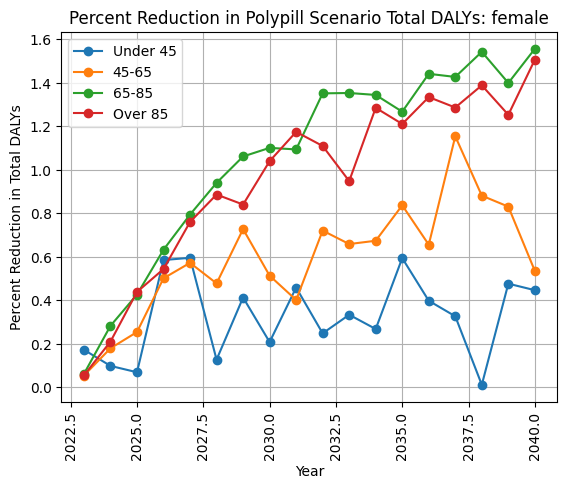

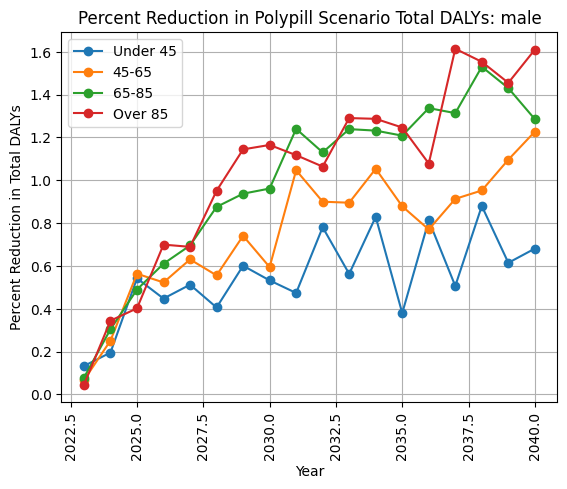

In [40]:
##Polypill Scenario First 
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='polypill_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Polypill Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

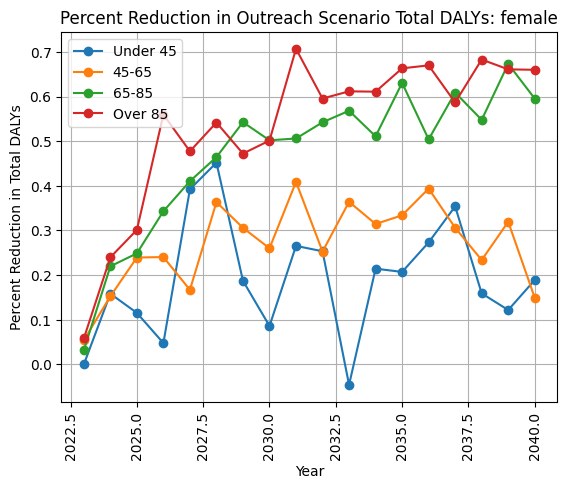

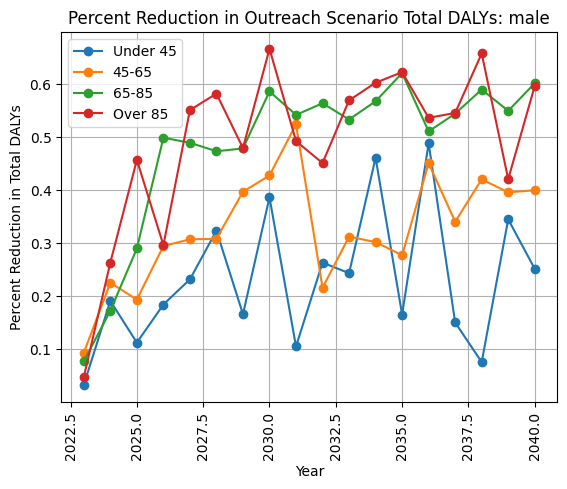

In [41]:
##Outreach Scenario  
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='outreach_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Outreach Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

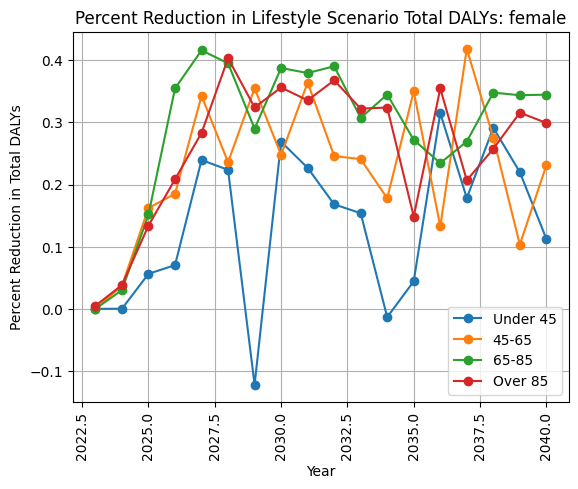

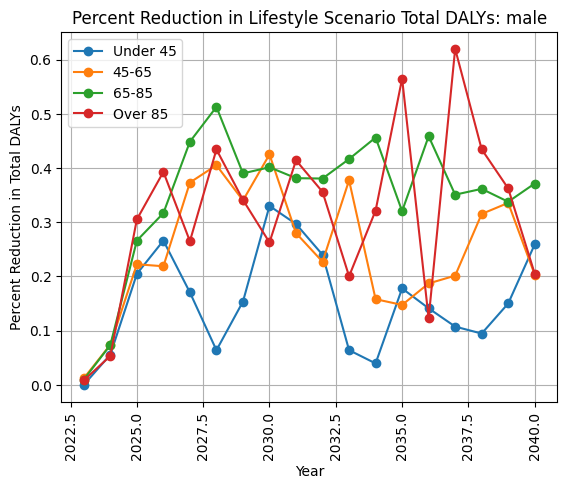

In [42]:
##Lifestyle Scenario  
for sex in daly_sum_percent.sex.unique(): 
    plt.figure()
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='under_45')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='45_to_65')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='65_to_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = daly_sum_percent.loc[(daly_sum_percent.sex==sex) & (daly_sum_percent.scenario=='lifestyle_100') & (daly_sum_percent.age_bucket=='over_85')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Lifestyle Scenario Total DALYs: {sex}')
    plt.legend(['Under 45','45-65','65-85','Over 85'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total DALYs')

# Deaths Averted

## Total Deaths Averted

In [27]:
deaths_all = deaths.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
deaths_all.head()

sex  year  scenario  input_draw   value
0  female  2023  baseline          29  4525.0
1  female  2023  baseline         232  4078.0
2  female  2023  baseline         357  4189.0
3  female  2023  baseline         394  4065.0
4  female  2023  baseline         602  4318.0

In [28]:
deaths_baseline = deaths_all.loc[deaths_all.scenario == 'baseline']
deaths_baseline = deaths_baseline.rename(columns = {'value':'baseline'})
deaths_total = deaths_all.merge(deaths_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
deaths_total['averted_count'] = deaths_total['baseline'] - deaths_total['value']
deaths_total['averted_percent'] = 100*((deaths_total['baseline'] - deaths_total['value'])/deaths_total['baseline'])
deaths_total

sex  year       scenario  input_draw   value  baseline  \
0     female  2023       baseline          29  4525.0    4525.0   
1     female  2023  lifestyle_100          29  4525.0    4525.0   
2     female  2023   lifestyle_50          29  4525.0    4525.0   
3     female  2023   outreach_100          29  4524.0    4525.0   
...      ...   ...            ...         ...     ...       ...   
2516    male  2040   outreach_100         946  5487.0    5481.0   
2517    male  2040    outreach_50         946  5480.0    5481.0   
2518    male  2040   polypill_100         946  5473.0    5481.0   
2519    male  2040    polypill_50         946  5475.0    5481.0   

      averted_count  averted_percent  
0               0.0         0.000000  
1               0.0         0.000000  
2               0.0         0.000000  
3               1.0         0.022099  
...             ...              ...  
2516           -6.0        -0.109469  
2517            1.0         0.018245  
2518            8.0         0.145959  
2519            6.0         0.109469  

[2520 rows x 8 columns]

In [29]:
deaths_summ_count = (deaths_total
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0   0.0  0.000
1  female  2023  lifestyle_100   0.1   0.0  0.775
2  female  2023   lifestyle_50   0.1   0.0  0.775
3  female  2023   outreach_100   1.9   0.0  5.325
4  female  2023    outreach_50   1.4   0.0  3.775

In [30]:
deaths_summ_percent = (deaths_total
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_percent.head()

sex  year       scenario      mean  2.5%     97.5%
0  female  2023       baseline  0.000000   0.0  0.000000
1  female  2023  lifestyle_100  0.002042   0.0  0.015829
2  female  2023   lifestyle_50  0.002042   0.0  0.015829
3  female  2023   outreach_100  0.043776   0.0  0.130505
4  female  2023    outreach_50  0.032418   0.0  0.092374

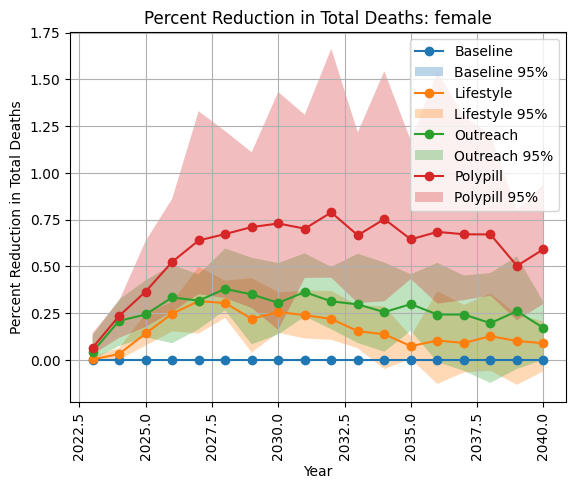

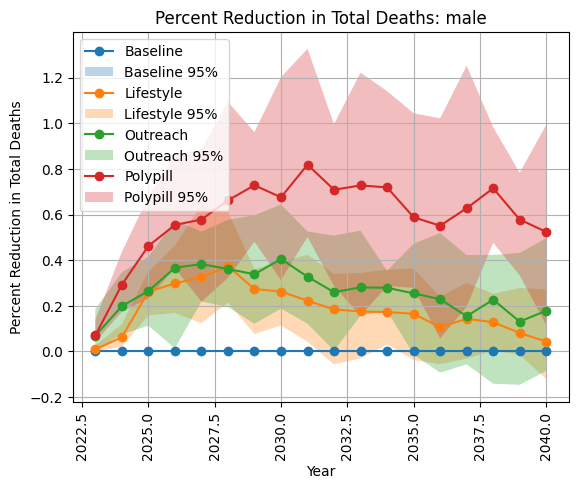

In [31]:
for sex in deaths_summ_percent.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Total Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Total Deaths')


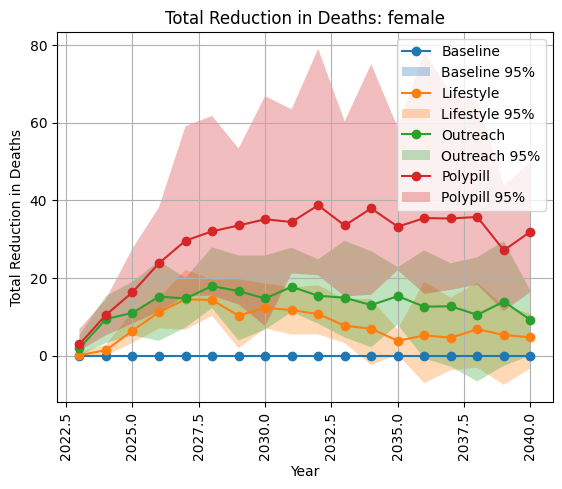

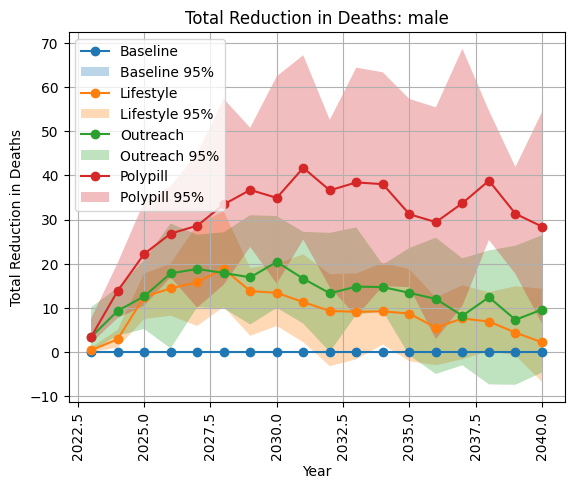

In [32]:
for sex in deaths_summ_count.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_count.loc[(deaths_summ_count.sex==sex) & (deaths_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in Deaths')


Note: This has not been multiplied up to reflect the full population 

## CVD Deaths Averted 

In [33]:
deaths_cvd = deaths.loc[deaths.cause != 'other_causes']
deaths_cvd = deaths_cvd.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
deaths_cvd.head()

sex  year  scenario  input_draw   value
0  female  2023  baseline          29  2520.0
1  female  2023  baseline         232  2813.0
2  female  2023  baseline         357  2406.0
3  female  2023  baseline         394  2923.0
4  female  2023  baseline         602  2596.0

In [34]:
deaths_baseline = deaths_cvd.loc[deaths_cvd.scenario == 'baseline']
deaths_baseline = deaths_baseline.rename(columns = {'value':'baseline'})
deaths_total = deaths_cvd.merge(deaths_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
deaths_total['averted_count'] = deaths_total['baseline'] - deaths_total['value']
deaths_total['averted_percent'] = 100*((deaths_total['baseline'] - deaths_total['value'])/deaths_total['baseline'])
deaths_total

sex  year       scenario  input_draw   value  baseline  \
0     female  2023       baseline          29  2520.0    2520.0   
1     female  2023  lifestyle_100          29  2520.0    2520.0   
2     female  2023   lifestyle_50          29  2520.0    2520.0   
3     female  2023   outreach_100          29  2519.0    2520.0   
...      ...   ...            ...         ...     ...       ...   
2516    male  2040   outreach_100         946  3628.0    3629.0   
2517    male  2040    outreach_50         946  3626.0    3629.0   
2518    male  2040   polypill_100         946  3605.0    3629.0   
2519    male  2040    polypill_50         946  3615.0    3629.0   

      averted_count  averted_percent  
0               0.0         0.000000  
1               0.0         0.000000  
2               0.0         0.000000  
3               1.0         0.039683  
...             ...              ...  
2516            1.0         0.027556  
2517            3.0         0.082667  
2518           24.0         0.661339  
2519           14.0         0.385781  

[2520 rows x 8 columns]

In [35]:
deaths_summ_percent = (deaths_total
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

deaths_summ_percent.head()

sex  year       scenario      mean  2.5%     97.5%
0  female  2023       baseline  0.000000   0.0  0.000000
1  female  2023  lifestyle_100  0.003520   0.0  0.027279
2  female  2023   lifestyle_50  0.003520   0.0  0.027279
3  female  2023   outreach_100  0.064494   0.0  0.160624
4  female  2023    outreach_50  0.050171   0.0  0.134110

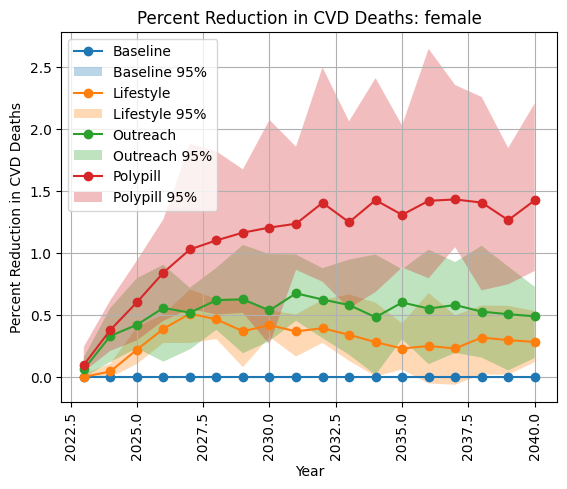

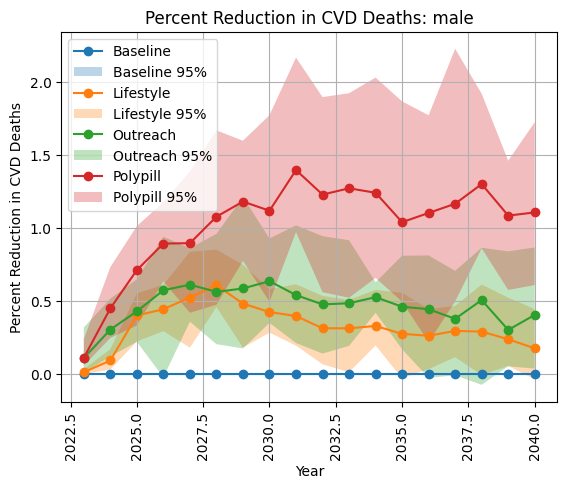

In [36]:
for sex in deaths_summ_percent.sex.unique(): 
    plt.figure()
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = deaths_summ_percent.loc[(deaths_summ_percent.sex==sex) & (deaths_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in CVD Deaths: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in CVD Deaths')


# First Time Incident Cases Averted

## Stroke Cases Averted

In [37]:
tran_stroke = tran.loc[tran.transition == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke']
tran_stroke = tran_stroke.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()

In [38]:
tran_baseline = tran_stroke.loc[tran_stroke.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'value':'baseline'})
tran_stroke = tran_stroke.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_stroke['averted_count'] = tran_stroke['baseline'] - tran_stroke['value']
tran_stroke['averted_percent'] = 100*((tran_stroke['baseline'] - tran_stroke['value'])/tran_stroke['baseline'])
tran_stroke.head()

sex  input_draw  year       scenario  value  baseline  averted_count  \
0  female          29  2023       baseline  508.0     508.0            0.0   
1  female          29  2023  lifestyle_100  507.0     508.0            1.0   
2  female          29  2023   lifestyle_50  507.0     508.0            1.0   
3  female          29  2023   outreach_100  503.0     508.0            5.0   
4  female          29  2023    outreach_50  507.0     508.0            1.0   

   averted_percent  
0         0.000000  
1         0.196850  
2         0.196850  
3         0.984252  
4         0.196850

In [39]:
stroke_summ_count = (tran_stroke
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0   0.0  0.000
1  female  2023  lifestyle_100   0.4   0.0  1.000
2  female  2023   lifestyle_50   0.3   0.0  1.000
3  female  2023   outreach_100   3.1   1.0  4.775
4  female  2023    outreach_50   1.5   0.0  3.000

In [40]:
stroke_summ_percent = (tran_stroke
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_summ_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100  0.098765  0.000000  0.285262
2  female  2023   lifestyle_50  0.074784  0.000000  0.285262
3  female  2023   outreach_100  0.720108  0.280664  1.020426
4  female  2023    outreach_50  0.358621  0.000000  0.706981

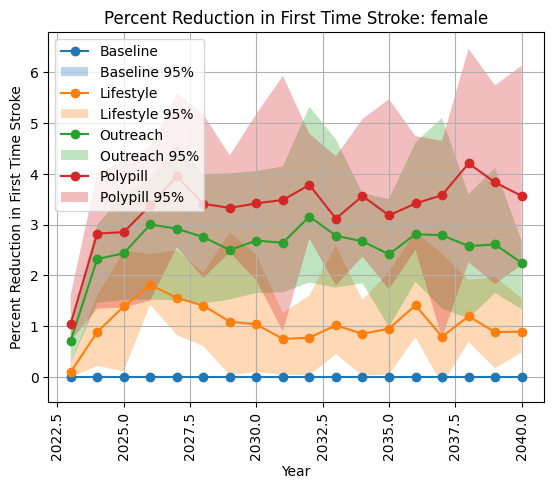

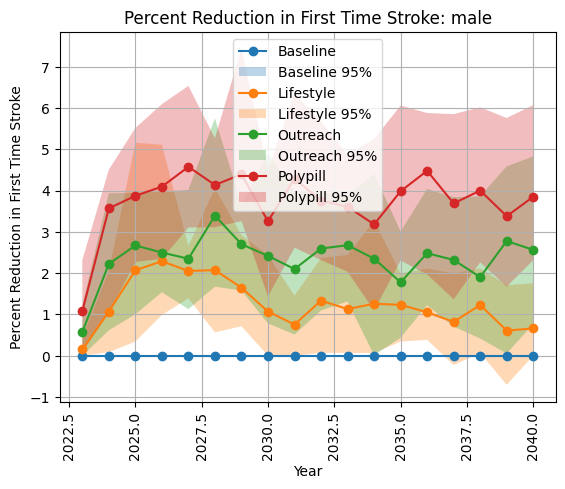

In [41]:
for sex in stroke_summ_percent.sex.unique(): 
    plt.figure()
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_percent.loc[(stroke_summ_percent.sex==sex) & (stroke_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Stroke: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time Stroke')


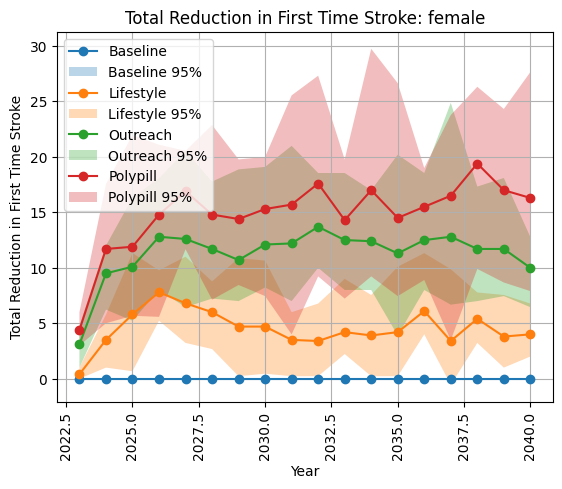

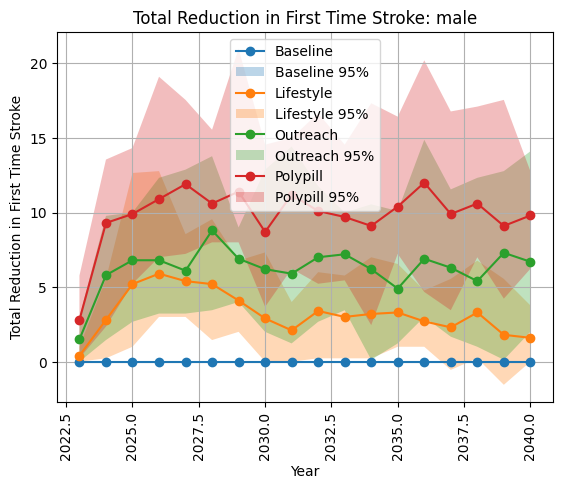

In [42]:
for sex in stroke_summ_count.sex.unique(): 
    plt.figure()
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = stroke_summ_count.loc[(stroke_summ_count.sex==sex) & (stroke_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time Stroke: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time Stroke')


Note: again, not multiplied up to represent all of Alabama

## First Time Acute MI

In [43]:
tran_mi = tran.loc[tran.transition == 'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']
tran_mi = tran_mi.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()

In [44]:
tran_baseline = tran_mi.loc[tran_mi.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'value':'baseline'})
tran_mi = tran_mi.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_mi['averted_count'] = tran_mi['baseline'] - tran_mi['value']
tran_mi['averted_percent'] = 100*((tran_mi['baseline'] - tran_mi['value'])/tran_mi['baseline'])
tran_mi.head()

sex  input_draw  year       scenario  value  baseline  averted_count  \
0  female          29  2023       baseline  497.0     497.0            0.0   
1  female          29  2023  lifestyle_100  497.0     497.0            0.0   
2  female          29  2023   lifestyle_50  497.0     497.0            0.0   
3  female          29  2023   outreach_100  494.0     497.0            3.0   
4  female          29  2023    outreach_50  496.0     497.0            1.0   

   averted_percent  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.603622  
4         0.201207

In [45]:
mi_summ_count = (tran_mi
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

mi_summ_count.head()

sex  year       scenario  mean  2.5%  97.5%
0  female  2023       baseline   0.0  0.00  0.000
1  female  2023  lifestyle_100   0.6  0.00  1.775
2  female  2023   lifestyle_50   0.2  0.00  1.000
3  female  2023   outreach_100   5.4  3.00  9.550
4  female  2023    outreach_50   2.9 -0.55  5.775

In [46]:
mi_summ_percent = (tran_mi
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

mi_summ_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100  0.106005  0.000000  0.302748
2  female  2023   lifestyle_50  0.028479  0.000000  0.153800
3  female  2023   outreach_100  0.945564  0.497773  1.498224
4  female  2023    outreach_50  0.496952 -0.122829  0.957328

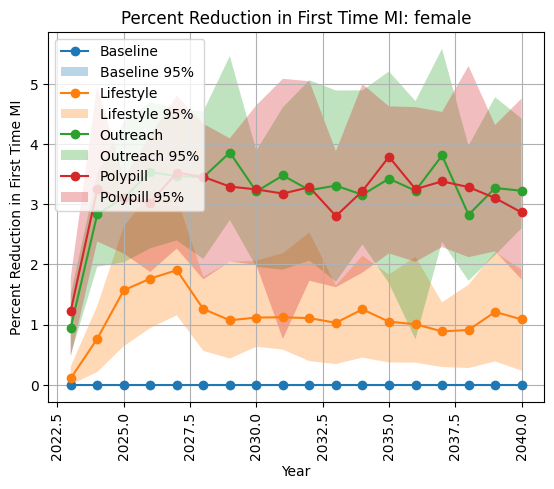

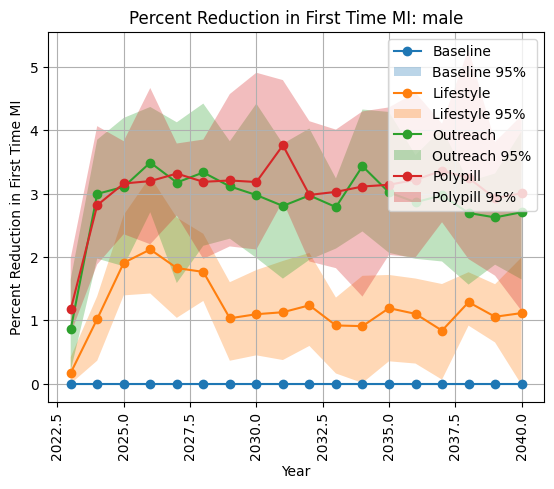

In [47]:
for sex in mi_summ_percent.sex.unique(): 
    plt.figure()
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_percent.loc[(mi_summ_percent.sex==sex) & (mi_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time MI: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time MI')


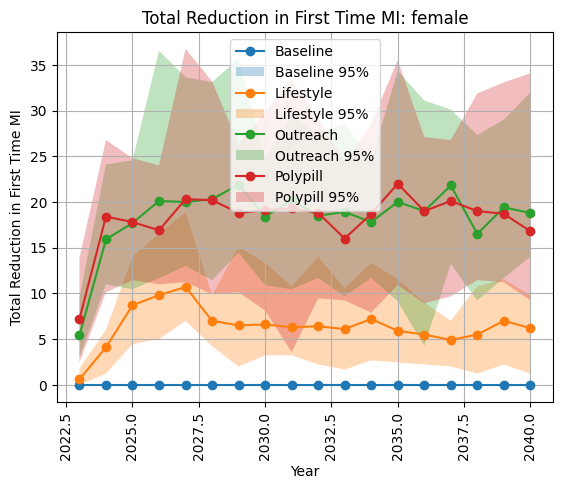

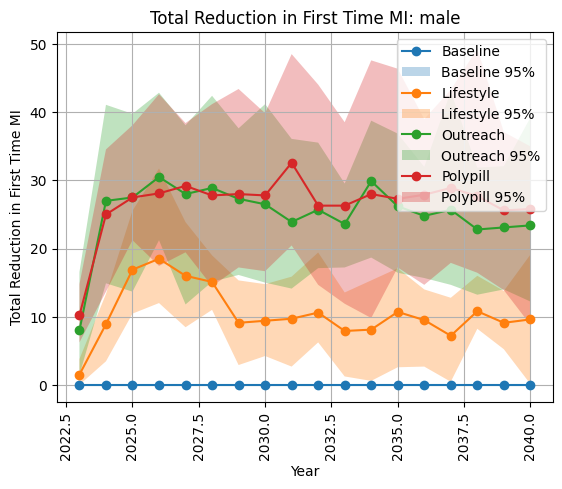

In [48]:
for sex in mi_summ_count.sex.unique(): 
    plt.figure()
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = mi_summ_count.loc[(mi_summ_count.sex==sex) & (mi_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time MI: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time MI')


## And First Time Heart Failure

In [96]:
tran_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_HF = tran_HF.groupby(['sex','input_draw','year','scenario']).value.sum().reset_index()

In [97]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure","ischemic_heart_disease_and_heart_failure_post_myocardial_infarction"])].reset_index()

In [98]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time_hf = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease"])].reset_index()
person_time_hf.state.unique()

array(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_heart_failure_residual'],
      dtype=object)

In [99]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age','sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age = person_time.loc[person_time.age != '25_to_29']
per_time_age = per_time_age.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
per_time_age.head()

sex  year  input_draw       scenario        ptvalue
0  female  2023          29       baseline  251757.908282
1  female  2023          29  lifestyle_100  251758.521561
2  female  2023          29   lifestyle_50  251758.521561
3  female  2023          29   outreach_100  251758.981520
4  female  2023          29    outreach_50  251759.134839

In [100]:
person_time_hf = person_time_hf.rename(columns = {'value':'ptvalue'})
per_time_group_hf = person_time_hf.groupby(['age','sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()

In [101]:
tran_HF_rate = tran_HF.merge(per_time_age[['sex', 'year', 'input_draw','scenario','ptvalue']], on=['sex', 'year', 'input_draw','scenario'])
tran_HF_rate['hf_rate'] = tran_HF_rate['value'] / tran_HF_rate['ptvalue']
tran_HF_rate.head()

sex  input_draw  year       scenario   value        ptvalue   hf_rate
0  female          29  2023       baseline  2345.0  251757.908282  0.009315
1  female          29  2023  lifestyle_100  2344.0  251758.521561  0.009311
2  female          29  2023   lifestyle_50  2344.0  251758.521561  0.009311
3  female          29  2023   outreach_100  2344.0  251758.981520  0.009310
4  female          29  2023    outreach_50  2342.0  251759.134839  0.009303

In [102]:
tran_baseline = tran_HF_rate.loc[tran_HF_rate.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'hf_rate':'baseline'})
tran_HF_rate = tran_HF_rate.merge(tran_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
tran_HF_rate['averted_count'] = tran_HF_rate['hf_rate'] - tran_HF_rate['baseline']
tran_HF_rate['averted_percent'] = 100*((tran_HF_rate['hf_rate'] - tran_HF_rate['baseline'])/tran_HF_rate['baseline'])
tran_HF_rate.head()

sex  input_draw  year       scenario   value        ptvalue   hf_rate  \
0  female          29  2023       baseline  2345.0  251757.908282  0.009315   
1  female          29  2023  lifestyle_100  2344.0  251758.521561  0.009311   
2  female          29  2023   lifestyle_50  2344.0  251758.521561  0.009311   
3  female          29  2023   outreach_100  2344.0  251758.981520  0.009310   
4  female          29  2023    outreach_50  2342.0  251759.134839  0.009303   

   baseline  averted_count  averted_percent  
0  0.009315       0.000000         0.000000  
1  0.009315      -0.000004        -0.042887  
2  0.009315      -0.000004        -0.042887  
3  0.009315      -0.000004        -0.043070  
4  0.009315      -0.000012        -0.128418

In [103]:
hf_baseline = per_time_group_hf.loc[per_time_group_hf.scenario == 'baseline']
hf_baseline = hf_baseline.rename(columns = {'ptvalue':'baseline'})
HF_rate_prev = per_time_group_hf.merge(hf_baseline[['age','sex','input_draw','year','baseline']], on=['age','sex','input_draw','year']) 
HF_rate_prev['averted_count'] = HF_rate_prev['baseline'] - HF_rate_prev['ptvalue']
HF_rate_prev['averted_percent'] = 100*((HF_rate_prev['baseline'] - HF_rate_prev['ptvalue'])/HF_rate_prev['baseline'])
HF_rate_prev.head()

age     sex  year  input_draw       scenario   ptvalue  baseline  \
0  25_to_29  female  2023          29       baseline  55.96167  55.96167   
1  25_to_29  female  2023          29  lifestyle_100  55.96167  55.96167   
2  25_to_29  female  2023          29   lifestyle_50  55.96167  55.96167   
3  25_to_29  female  2023          29   outreach_100  55.96167  55.96167   
4  25_to_29  female  2023          29    outreach_50  55.96167  55.96167   

   averted_count  averted_percent  
0            0.0              0.0  
1            0.0              0.0  
2            0.0              0.0  
3            0.0              0.0  
4            0.0              0.0

In [89]:
HF_summ_count = (tran_HF_rate
                      .groupby(['sex', 'year','scenario'])
                      .averted_count.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_count.head()

sex  year       scenario      mean      2.5%         97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000e+00
1  female  2023  lifestyle_100 -0.000003 -0.000004  0.000000e+00
2  female  2023   lifestyle_50 -0.000002 -0.000007  3.108094e-06
3  female  2023   outreach_100 -0.000013 -0.000027 -3.901999e-09
4  female  2023    outreach_50 -0.000012 -0.000027  6.145119e-06

In [90]:
HF_summ_percent = (tran_HF_rate
                      .groupby(['sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_percent.head()

sex  year       scenario      mean      2.5%     97.5%
0  female  2023       baseline  0.000000  0.000000  0.000000
1  female  2023  lifestyle_100 -0.027344 -0.042558  0.000000
2  female  2023   lifestyle_50 -0.019909 -0.065593  0.026643
3  female  2023   outreach_100 -0.122454 -0.272079 -0.000039
4  female  2023    outreach_50 -0.108002 -0.235448  0.064201

In [104]:
HF_prev_percent = (HF_rate_prev
                      .groupby(['age','sex', 'year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_prev_percent.head()

age     sex  year       scenario          mean          2.5%  97.5%
0  25_to_29  female  2023       baseline  0.000000e+00  0.000000e+00    0.0
1  25_to_29  female  2023  lifestyle_100 -3.507442e-15 -2.051013e-14    0.0
2  25_to_29  female  2023   lifestyle_50 -3.507442e-15 -2.051013e-14    0.0
3  25_to_29  female  2023   outreach_100 -1.213191e-15 -9.402227e-15    0.0
4  25_to_29  female  2023    outreach_50 -3.507442e-15 -2.051013e-14    0.0

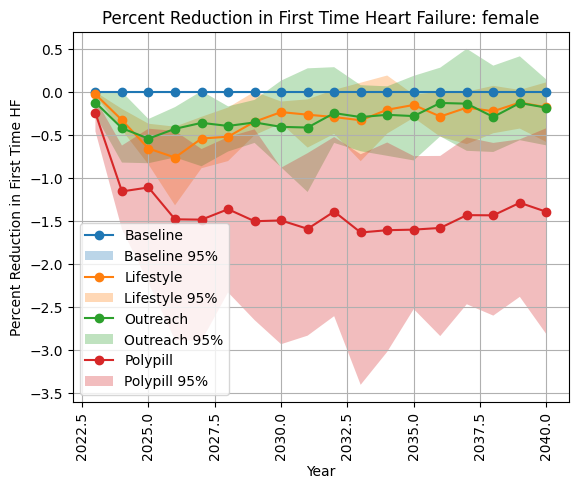

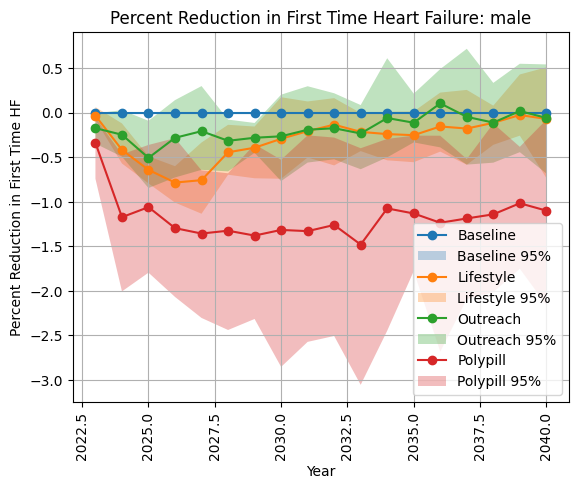

In [91]:
for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Heart Failure: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')


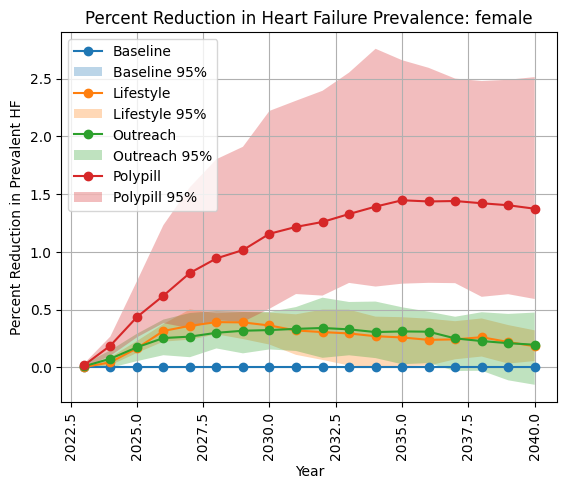

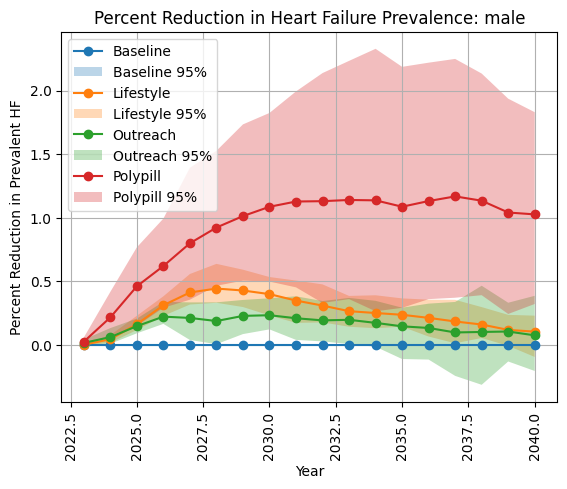

In [92]:
for sex in HF_prev_percent.sex.unique(): 
    plt.figure()
    subdata = HF_prev_percent.loc[(HF_prev_percent.sex==sex) & (HF_prev_percent.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_prev_percent.loc[(HF_prev_percent.sex==sex) & (HF_prev_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_prev_percent.loc[(HF_prev_percent.sex==sex) & (HF_prev_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_prev_percent.loc[(HF_prev_percent.sex==sex) & (HF_prev_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Prevalent HF')


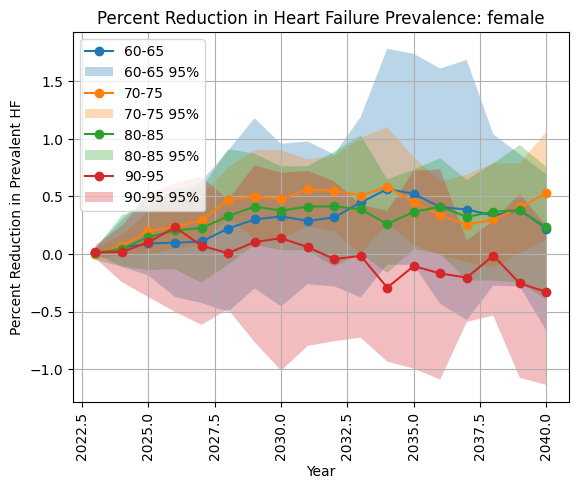

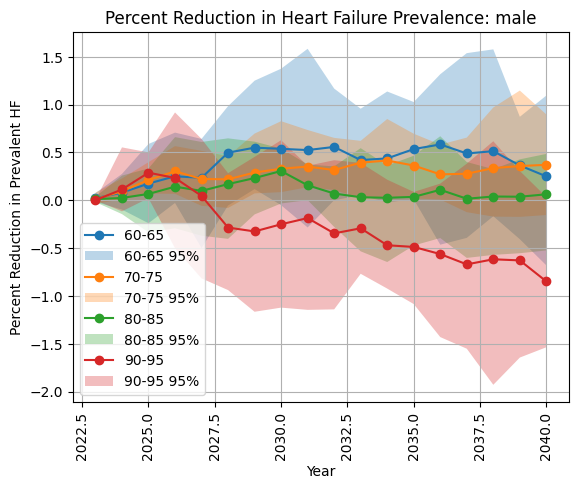

In [113]:
for sex in HF_prev_percent.sex.unique(): 
    plt.figure()
    subdata = HF_prev_percent.loc[(HF_prev_percent.sex==sex) & (HF_prev_percent.scenario=='outreach_100') & (HF_prev_percent.age=='60_to_64')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_prev_percent.loc[(HF_prev_percent.sex==sex) & (HF_prev_percent.scenario=='outreach_100') & (HF_prev_percent.age=='70_to_74')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_prev_percent.loc[(HF_prev_percent.sex==sex) & (HF_prev_percent.scenario=='outreach_100') & (HF_prev_percent.age=='80_to_84')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_prev_percent.loc[(HF_prev_percent.sex==sex) & (HF_prev_percent.scenario=='outreach_100') & (HF_prev_percent.age=='90_to_94')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in Heart Failure Prevalence: {sex}')
    plt.legend(['60-65','60-65 95%','70-75','70-75 95%','80-85','80-85 95%','90-95','90-95 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in Prevalent HF')


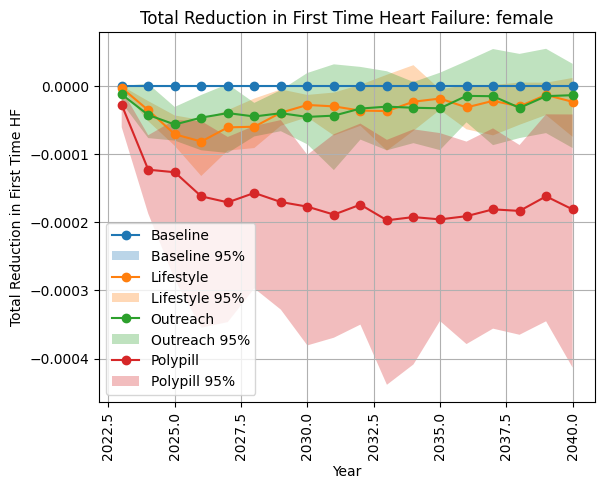

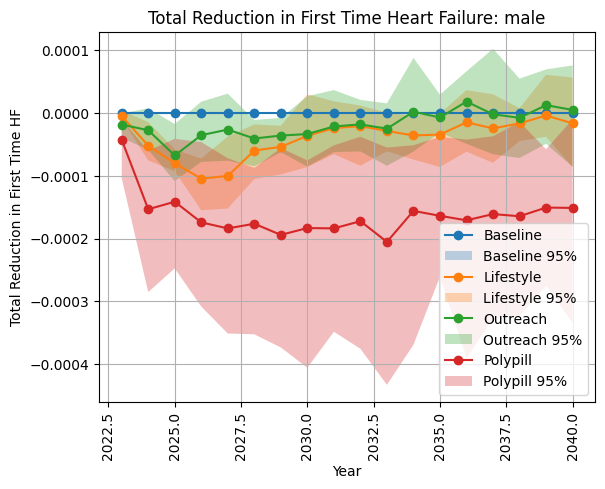

In [57]:
for sex in HF_summ_count.sex.unique(): 
    plt.figure()
    subdata = HF_summ_count.loc[(HF_summ_count.sex==sex) & (HF_summ_count.scenario=='baseline')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_count.loc[(HF_summ_count.sex==sex) & (HF_summ_count.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_count.loc[(HF_summ_count.sex==sex) & (HF_summ_count.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_count.loc[(HF_summ_count.sex==sex) & (HF_summ_count.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Total Reduction in First Time Heart Failure: {sex}')
    plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Total Reduction in First Time HF')


## Heart Failure Reduction by Age Group

In [58]:
tran_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
tran_HF = tran_HF.groupby(['sex','age','input_draw','year','scenario']).value.sum().reset_index()

In [59]:
tran_HF_rate = tran_HF.merge(per_time_group[['age','sex', 'year', 'input_draw','scenario','ptvalue']], on=['age','sex', 'year', 'input_draw','scenario'])
tran_HF_rate['hf_rate'] = tran_HF_rate['value'] / tran_HF_rate['ptvalue']
tran_HF_rate.head()

sex       age  input_draw  year       scenario  value       ptvalue  \
0  female  25_to_29          29  2023       baseline   14.0  26939.181383   
1  female  25_to_29          29  2023  lifestyle_100   14.0  26939.181383   
2  female  25_to_29          29  2023   lifestyle_50   14.0  26939.181383   
3  female  25_to_29          29  2023   outreach_100   14.0  26939.181383   
4  female  25_to_29          29  2023    outreach_50   14.0  26939.181383   

   hf_rate  
0  0.00052  
1  0.00052  
2  0.00052  
3  0.00052  
4  0.00052

In [60]:
tran_baseline = tran_HF_rate.loc[tran_HF_rate.scenario == 'baseline']
tran_baseline = tran_baseline.rename(columns = {'hf_rate':'baseline'})
tran_HF_rate = tran_HF_rate.merge(tran_baseline[['sex','age','input_draw','year','baseline']], on=['sex','age','input_draw','year']) 
tran_HF_rate['averted_count'] = tran_HF_rate['baseline'] - tran_HF_rate['hf_rate']
tran_HF_rate['averted_percent'] = 100*((tran_HF_rate['baseline'] - tran_HF_rate['hf_rate'])/tran_HF_rate['baseline'])
tran_HF_rate.head()

sex       age  input_draw  year       scenario  value       ptvalue  \
0  female  25_to_29          29  2023       baseline   14.0  26939.181383   
1  female  25_to_29          29  2023  lifestyle_100   14.0  26939.181383   
2  female  25_to_29          29  2023   lifestyle_50   14.0  26939.181383   
3  female  25_to_29          29  2023   outreach_100   14.0  26939.181383   
4  female  25_to_29          29  2023    outreach_50   14.0  26939.181383   

   hf_rate  baseline  averted_count  averted_percent  
0  0.00052   0.00052            0.0              0.0  
1  0.00052   0.00052            0.0              0.0  
2  0.00052   0.00052            0.0              0.0  
3  0.00052   0.00052            0.0              0.0  
4  0.00052   0.00052            0.0              0.0

In [61]:
HF_summ_percent = (tran_HF_rate
                      .groupby(['sex', 'age','year','scenario'])
                      .averted_percent.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_summ_percent.head()

sex       age  year       scenario  mean  2.5%  97.5%
0  female  25_to_29  2023       baseline   0.0   0.0    0.0
1  female  25_to_29  2023  lifestyle_100   0.0   0.0    0.0
2  female  25_to_29  2023   lifestyle_50   0.0   0.0    0.0
3  female  25_to_29  2023   outreach_100   0.0   0.0    0.0
4  female  25_to_29  2023    outreach_50   0.0   0.0    0.0

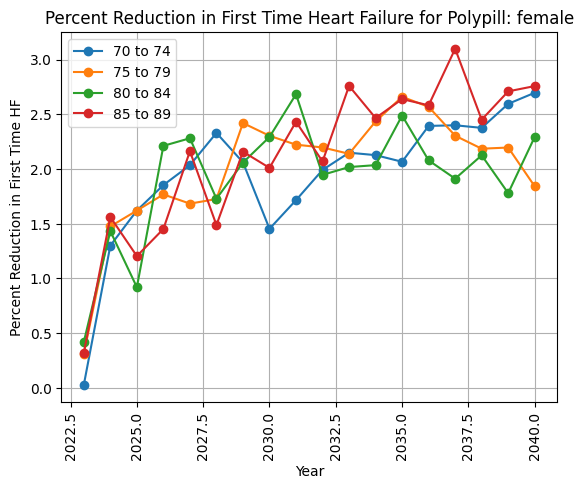

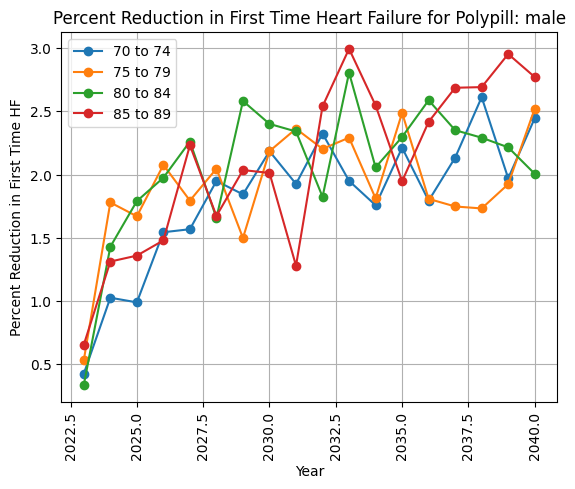

In [62]:
## For Polypill

for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='70_to_74') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='75_to_79') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='80_to_84') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='85_to_89') & (HF_summ_percent.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Heart Failure for Polypill: {sex}')
    plt.legend(['70 to 74','75 to 79','80 to 84','85 to 89'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

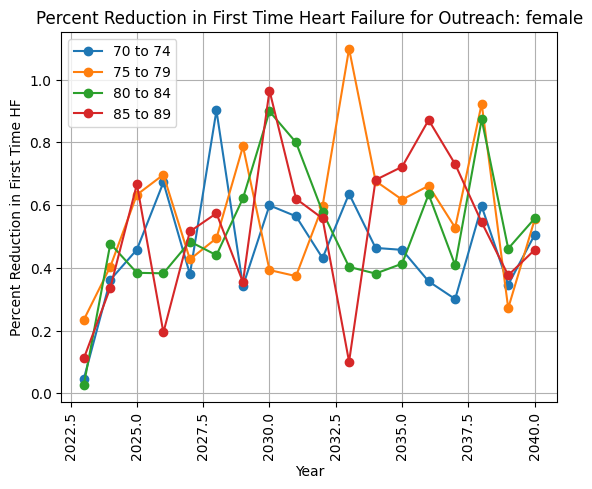

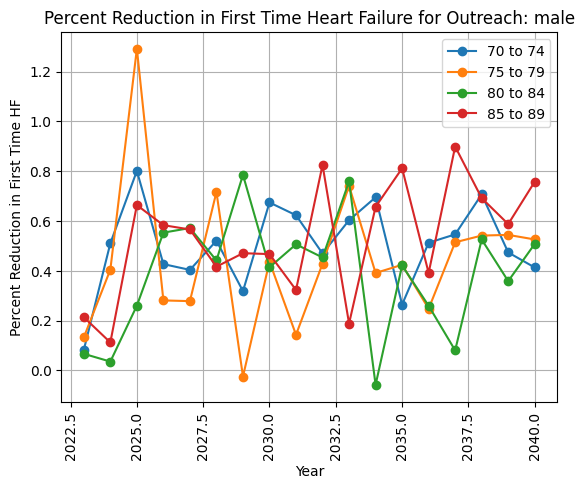

In [63]:
## For Outreach

for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='70_to_74') & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='75_to_79') & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='80_to_84') & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='85_to_89') & (HF_summ_percent.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Heart Failure for Outreach: {sex}')
    plt.legend(['70 to 74','75 to 79','80 to 84','85 to 89'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

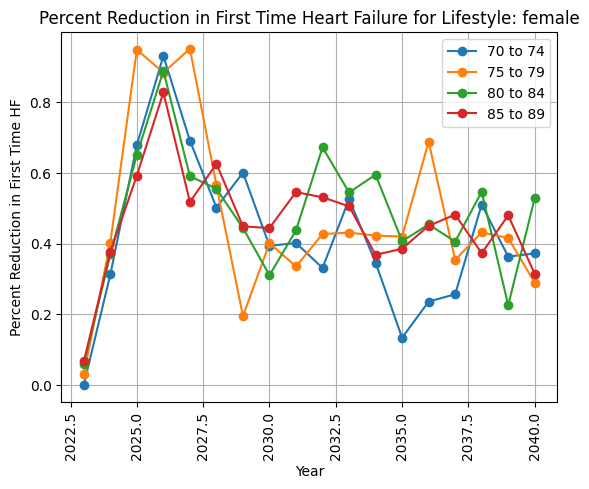

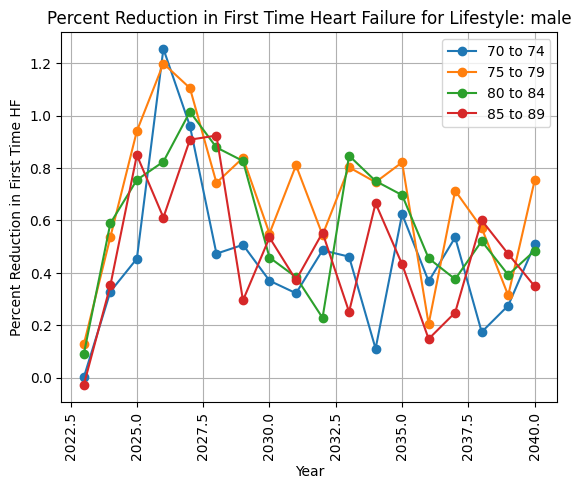

In [64]:
## For Lifestyle

for sex in HF_summ_percent.sex.unique(): 
    plt.figure()
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='70_to_74') & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='75_to_79') & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='80_to_84') & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    subdata = HF_summ_percent.loc[(HF_summ_percent.sex==sex) & (HF_summ_percent.age=='85_to_89') & (HF_summ_percent.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['mean'], marker = 'o')
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
    plt.title(f'Percent Reduction in First Time Heart Failure for Lifestyle: {sex}')
    plt.legend(['70 to 74','75 to 79','80 to 84','85 to 89'])
    plt.xticks(rotation=90) 
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Percent Reduction in First Time HF')

## Testing Input Draws

### HF Prevalence Time Averted

In [116]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time_hf = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease"])].reset_index()
person_time_hf = person_time_hf.rename(columns = {'value':'ptvalue'})
per_time_group_hf = person_time_hf.groupby(['year', 'input_draw','scenario']).ptvalue.sum().reset_index()

In [117]:
hf_baseline = per_time_group_hf.loc[per_time_group_hf.scenario == 'baseline']
hf_baseline = hf_baseline.rename(columns = {'ptvalue':'baseline'})
HF_rate_prev = per_time_group_hf.merge(hf_baseline[['input_draw','year','baseline']], on=['input_draw','year']) 
HF_rate_prev['averted_count'] = HF_rate_prev['baseline'] - HF_rate_prev['ptvalue']
HF_rate_prev['averted_percent'] = 100*((HF_rate_prev['baseline'] - HF_rate_prev['ptvalue'])/HF_rate_prev['baseline'])
HF_rate_prev.head()

year  input_draw       scenario       ptvalue      baseline  averted_count  \
0  2023          29       baseline  16682.403833  16682.403833       0.000000   
1  2023          29  lifestyle_100  16681.637235  16682.403833       0.766598   
2  2023          29   lifestyle_50  16681.790554  16682.403833       0.613279   
3  2023          29   outreach_100  16680.640657  16682.403833       1.763176   
4  2023          29    outreach_50  16680.947296  16682.403833       1.456537   

   averted_percent  
0         0.000000  
1         0.004595  
2         0.003676  
3         0.010569  
4         0.008731

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

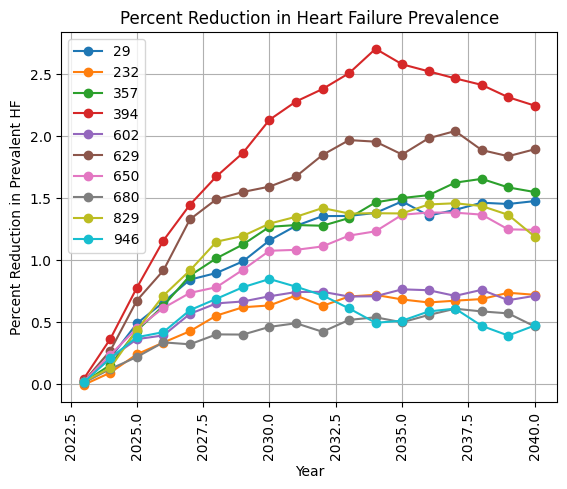

In [119]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='polypill_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Polypill')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

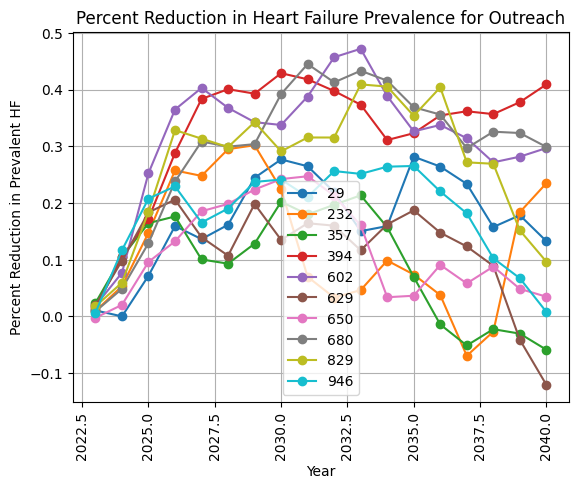

In [120]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='outreach_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Outreach')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

Text(0, 0.5, 'Percent Reduction in Prevalent HF')

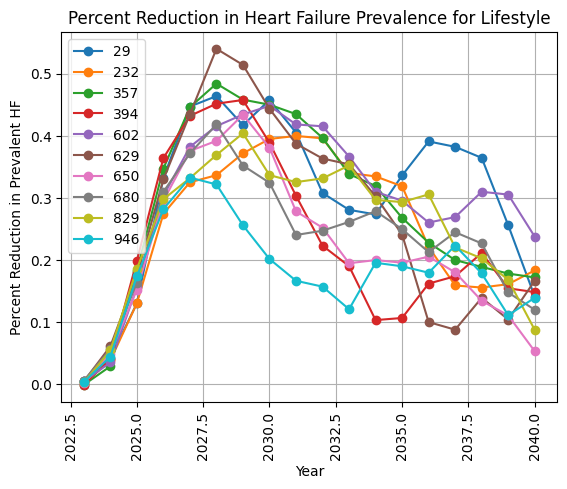

In [121]:
plt.figure()
for draw in HF_rate_prev.input_draw.unique(): 
    subdata = HF_rate_prev.loc[(HF_rate_prev.input_draw==draw) & (HF_rate_prev.scenario=='lifestyle_100')]
    plt.plot(subdata['year'], subdata['averted_percent'], marker = 'o')
plt.title(f'Percent Reduction in Heart Failure Prevalence for Lifestyle')
plt.legend(HF_rate_prev.input_draw.unique())
plt.xticks(rotation=90) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percent Reduction in Prevalent HF')

### DALYs Averted

In [123]:
daly_total_rate = daly_total.merge(per_time_age[['sex','input_draw','year','scenario','ptvalue']], on=['sex','input_draw','year','scenario'])
daly_total_rate['daly_rate'] = daly_total_rate['daly'] / daly_total_rate['ptvalue']
daly_total_rate.head()

sex       age  input_draw  year  scenario         daly        ptvalue  \
0  female  25_to_29          29  2023  baseline  1953.773422  251757.908282   
1  female  30_to_34          29  2023  baseline  2613.284063  251757.908282   
2  female  35_to_39          29  2023  baseline  2646.192783  251757.908282   
3  female  40_to_44          29  2023  baseline  4136.507025  251757.908282   
4  female  45_to_49          29  2023  baseline  3989.977553  251757.908282   

   daly_rate  
0   0.007761  
1   0.010380  
2   0.010511  
3   0.016430  
4   0.015848

In [124]:
daly_total_baseline = daly_total_rate.loc[daly_total_rate.scenario == 'baseline']
daly_total_baseline = daly_total_baseline.rename(columns = {'daly_rate':'baseline'})
daly_total_rate = daly_total_rate.merge(daly_total_baseline[['sex','input_draw','year','baseline']], on=['sex','input_draw','year']) 
daly_total_rate['averted_count'] = daly_total_rate['daly_rate'] - daly_total_rate['baseline']
daly_total_rate['averted_percent'] = 100*((daly_total_rate['daly_rate'] - daly_total_rate['baseline'])/daly_total_rate['baseline'])
daly_total_rate.head()

sex       age  input_draw  year  scenario         daly        ptvalue  \
0  female  25_to_29          29  2023  baseline  1953.773422  251757.908282   
1  female  25_to_29          29  2023  baseline  1953.773422  251757.908282   
2  female  25_to_29          29  2023  baseline  1953.773422  251757.908282   
3  female  25_to_29          29  2023  baseline  1953.773422  251757.908282   
4  female  25_to_29          29  2023  baseline  1953.773422  251757.908282   

   daly_rate  baseline  averted_count  averted_percent  
0   0.007761  0.007761       0.000000         0.000000  
1   0.007761  0.010380      -0.002620       -25.236852  
2   0.007761  0.010511      -0.002750       -26.166626  
3   0.007761  0.016430      -0.008670       -52.767555  
4   0.007761  0.015848      -0.008088       -51.032972